In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-10-01 18:51:11,183 func.utils 347 [INFO]    [logger_func] start 


In [ ]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

# paths_train = glob('../submit/re_sub/50*_train.gz')
# paths_test  = glob('../submit/re_sub/50*_test.gz')
# paths_train += glob('../submit/re_sub/Tran*_train.gz')
# paths_test  += glob('../submit/re_sub/Tran*_test.gz')
# paths_train += glob('../submit/re_sub/is*_train.gz')
# paths_test  += glob('../submit/re_sub/is*_test.gz')

paths_train = glob('../submit/re_sub/*_train.gz')
paths_test  = glob('../submit/re_sub/*_test.gz')
paths_train += glob('../submit/add_feature/*_train.gz')
paths_test  += glob('../submit/add_feature/*_test.gz')

print(len(paths_train))
# sys.exit()
# paths_train += glob('../feature/valid_trush/528*uid2*_train.gz')
# paths_test  += glob('../feature/valid_trush/528*uid2*_test.gz')

# for path in paths_train:
#     if path.count('C14_ratio'):
#         paths_train.remove(path)
        
# for path in paths_test:
#     if path.count('C14_ratio'):
#         paths_test.remove(path)
    
# paths_train = glob('../feature/raw_use/*_train.gz')
# paths_test = glob('../feature/raw_use/*_test.gz')
# paths_train = [path for path in paths_train if filter_feature(path) ]
# paths_test = [path for path in paths_test if filter_feature(path) ]

# paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature = sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/valid_use/*_test.gz'))
paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

2302


In [ ]:
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# bear = pd.read_csv(same_user_path)
# bear = bear[[COLUMN_ID, 'predicted_user_id']]
# max_id = bear['predicted_user_id'].max()
# bear.loc[bear[bear['predicted_user_id'].isnull()].index, 'predicted_user_id'] = np.arange(
#     bear['predicted_user_id'].isnull().sum() ) + 1 + max_id
# bear['predicted_user_id'] =  bear['predicted_user_id'].astype('int')
# bear.shape

In [ ]:
is_submit = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
# tmp_train = tmp_train.merge(bear[[COLUMN_ID, 'predicted_user_id']], how='inner', on=COLUMN_ID)
# COLUMN_GROUP = 'predicted_user_id'
# COLUMNS_IGNORE.append('predicted_user_id')

### DT-M
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# tmp_train[COLUMN_GROUP] = tmp_train['528__ugr_uid3_Regist_date_agg_V95_137_mean_mean'].fillna(0)

#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
#     params['learning_rate'] = 0.1
    params["early_stopping_rounds"] = 100


use_cols = [col for col in df_train.columns if col not in COLUMNS_IGNORE]
logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.910362
[400]	valid_0's auc: 0.924086
[600]	valid_0's auc: 0.930323
[800]	valid_0's auc: 0.933287
[1000]	valid_0's auc: 0.934959
[1200]	valid_0's auc: 0.936048
[1400]	valid_0's auc: 0.936699
[1600]	valid_0's auc: 0.937038
[1800]	valid_0's auc: 0.937435
[2000]	valid_0's auc: 0.937654
[2200]	valid_0's auc: 0.937838
Early stopping, best iteration is:
[2160]	valid_0's auc: 0.937912


2019-09-30 21:47:46,204 func.utils 162 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9379121139138781 | Bear's...PB:0.9836241572479938 PV:0.9808308979086339 All:0.981814715628892 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 690 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.940475
[400]	valid_0's auc: 0.951167
[600]	valid_0's auc: 0.956054
[800]	valid_0's auc: 0.95832
[1000]	valid_0's auc: 0.95917
[1200]	valid_0's auc: 0.959854
[1400]	valid_0's auc: 0.960115
Early stopping, best iteration is:
[1350]	valid_0's auc: 0.960181
[  * Fold1 Validation-DT-M 2018-3: 101968] done in 367 s


2019-09-30 21:54:02,743 func.utils 162 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9601810093355765 | Bear's...PB:0.9739226372363079 PV:0.9765308968561093 All:0.975955331459457 


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.939611
[400]	valid_0's auc: 0.953173
[600]	valid_0's auc: 0.959406
[800]	valid_0's auc: 0.962553
[1000]	valid_0's auc: 0.96401
[1200]	valid_0's auc: 0.965167
[1400]	valid_0's auc: 0.965835
[1600]	valid_0's auc: 0.966397
[1800]	valid_0's auc: 0.966706
Early stopping, best iteration is:
[1806]	valid_0's auc: 0.966722


2019-09-30 22:04:11,820 func.utils 162 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.966721703177625 | Bear's...PB:0.9814805357984782 PV:0.9806445133653067 All:0.9808333450702099 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 601 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.935226
[400]	valid_0's auc: 0.945073
[600]	valid_0's auc: 0.949396
[800]	valid_0's auc: 0.951629
[1000]	valid_0's auc: 0.952907
[1200]	valid_0's auc: 0.953748
[1400]	valid_0's auc: 0.954247
[1600]	valid_0's auc: 0.954618
Early stopping, best iteration is:
[1581]	valid_0's auc: 0.954627


2019-09-30 22:12:33,886 func.utils 162 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9546265974774295 | Bear's...PB:0.945528263144081 PV:0.9450608534570167 All:0.946175521972439 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 488 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.951384
[400]	valid_0's auc: 0.960488
[600]	valid_0's auc: 0.964573
[800]	valid_0's auc: 0.966214
[1000]	valid_0's auc: 0.966854
[1200]	valid_0's auc: 0.967541
[1400]	valid_0's auc: 0.967927
[1600]	valid_0's auc: 0.968039
[1800]	valid_0's auc: 0.968121
Early stopping, best iteration is:
[1721]	valid_0's auc: 0.968146


2019-09-30 22:20:33,921 func.utils 162 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9681457315296392 | Bear's...PB:0.9850813447929 PV:0.9819930603552621 All:0.9830182484958355 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 470 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.94818
[400]	valid_0's auc: 0.960364
[600]	valid_0's auc: 0.965724
[800]	valid_0's auc: 0.968128
[1000]	valid_0's auc: 0.969491
[1200]	valid_0's auc: 0.970078
[1400]	valid_0's auc: 0.970418
[1600]	valid_0's auc: 0.97067
Early stopping, best iteration is:
[1696]	valid_0's auc: 0.970746
[  * Make Prediction Result File.] done in 49 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9566 / 0.9526928286639303
  *  (506691,) (506691,)
  * LB0.9609 / 0.9744973976371211


2019-09-30 22:30:48,679 func.utils 348 [INFO]    [eval_train] * CV: 0.9597222342884243 | BestIter: 1719.0 


  *  (506691,) (506691,)
  * LB0.9566 / 0.0011451747709806074
* Training Feature Importance


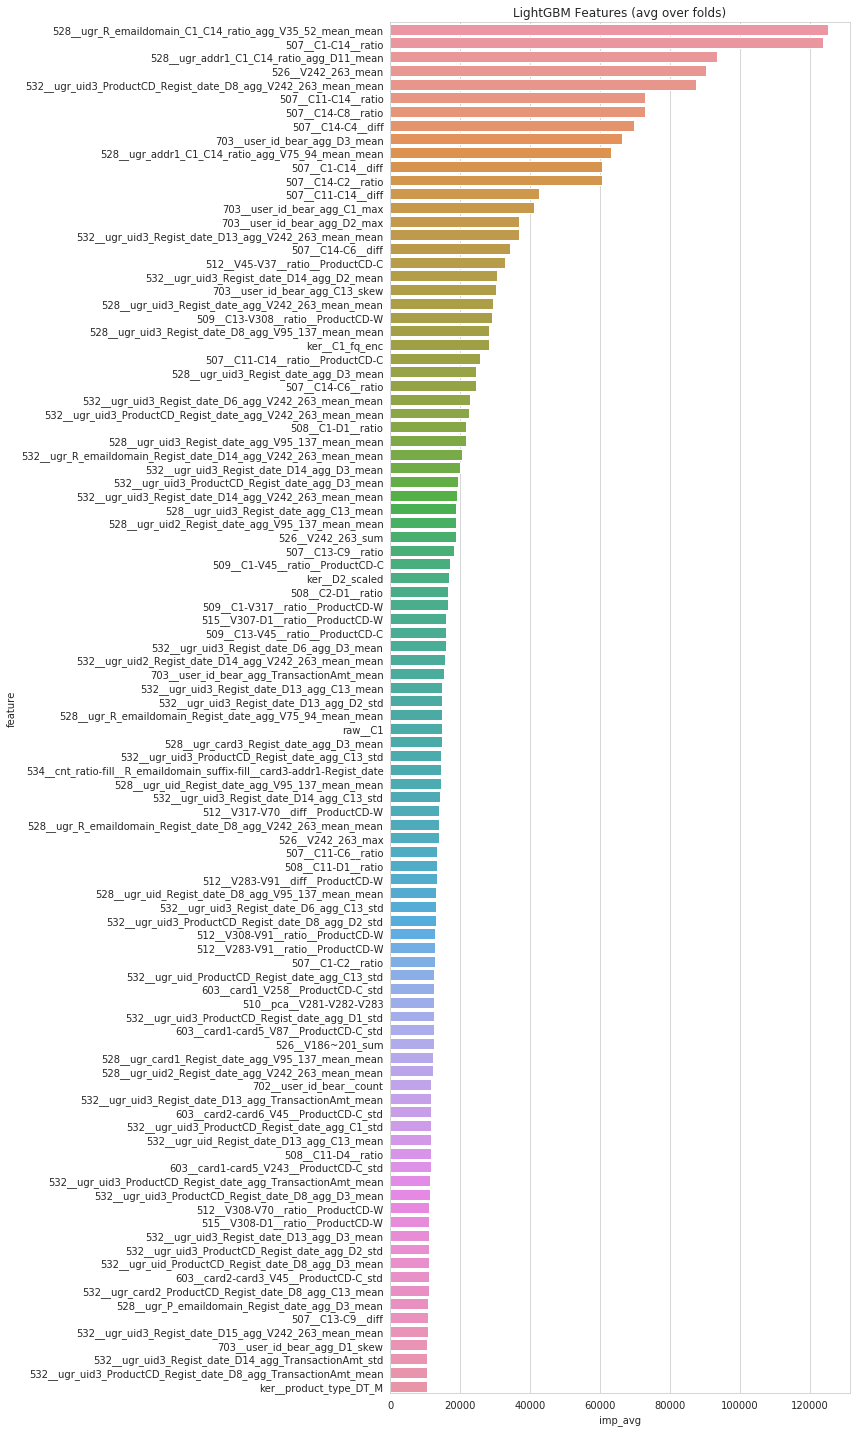

Setup Dataset dim_ml_dataset.


NameError: name 'list_result_feim' is not defined

In [5]:
feim, _ = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

In [ ]:
feim = list_result_feim[0]
# feim = read_pkl_gzip('../output/feature_importances/20190926_1350__CV0-9604930198337085__feature1942.gz')
# feim = read_pkl_gzip('../output/feature_importances/20190925_1450__CV0-9581588018233685__feature2114.gz')
# key1 = '532_'
# key2 = '_D'

# idx = [col for col in feim.index if
#        (
#        col.count(key1)
# #        and
#        or
#        col.count(key2)
#        )
#        and not col.count('ratio')
#        and not col.count('diff')
#       ]
# feim = feim.loc[idx]
# feim.sort_values(by='imp_avg', inplace=True, ascending=False)
# print(feim.shape)
# feim.tail(100)
feim

In [9]:
cnt = 0
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim.index:
# for feature_name in feim.tail(100).index:
# for feature_name in feim[feim['imp_avg']<6000].index:
    
    if not feature_name.count('mean'):
        continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = '../submit/re_sub'
#     from_dir = '../submit/add_feature/'
#     from_dir = 'org_use'
#     from_dir = 'valid_use'
#     from_dir = 'valid_trush'
#     to_dir = '../submit/escape'
#     to_dir = '../submit/add_feature'
#     to_dir = '../submit/add_feature'
#     to_dir = 'valid_trush'
#     to_dir = 'valid_use'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
#         print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
        cnt+=1
    except FileNotFoundError:
        print(feature_name)
print(cnt)

NameError: name 'feim' is not defined

In [ ]:
is_submit = [True, False][0]
has_dec = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# 2017-12抜いてみる
# if not has_dec:
#     tmp_train = tmp_train[tmp_train[COLUMN_GROUP]!='2017-12']
#     Y = Y.loc[tmp_train.index]
#     n_splits = 5


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
    params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

  * Diff Features: 1


2019-09-29 06:04:52,252 func.utils 111 [INFO]    [<module>] * EXP: dataset new_set (590540, 1682) lr 0.01  


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.905843
[400]	valid_0's auc: 0.919909
[600]	valid_0's auc: 0.926924
[800]	valid_0's auc: 0.930362
